[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# 研究助手 Research Assistant

## 回顾 Review

我们已经涵盖了几个主要的 LangGraph 主题：

* 记忆 Memory
* 人类参与 Human-in-the-loop
* 可控性 Controllability 


现在，我们将把这些想法结合起来，解决人工智能最受欢迎的应用之一：研究自动化。

研究往往是繁琐的工作，通常交由分析师来完成。AI 在这方面具有巨大的辅助潜力。

然而，研究需要高度定制化：原始的大模型输出往往并不适合真实世界的决策流程。

基于 AI 的定制化 [研究与报告生成](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) 工作流是解决这一问题的有前景的途径。

## 目标 Goal

我们的目标是围绕对话模型，构建一个轻量级的多智能体系统，用于定制化研究流程。

`来源选择`  
* 用户可以为他们的研究选择任意一组输入来源。  

`规划`  
* 用户提供一个主题，系统会生成一个 AI 分析师团队，每个分析师专注于一个子主题。  
* 在研究开始之前，会通过 `人类参与（Human-in-the-loop）` 来细化这些子主题。  

`大模型利用`  
* 每个分析师将使用选定的来源，与一个专家型 AI 进行深入访谈。  
* 访谈将是多轮对话，以提取详细见解，正如 [STORM](https://arxiv.org/abs/2402.14207) 论文中展示的那样。  
* 这些访谈会通过 `子图（sub-graphs）` 来记录，包括其内部状态。  

`研究过程`  
* 专家们将并行收集信息，以回答分析师提出的问题。  
* 所有访谈将通过 `map-reduce` 同步进行。  

`输出格式`  
* 每次访谈收集的见解将被综合为最终报告。  
* 我们会使用可定制的提示词来生成报告，从而支持灵活的输出格式。  

![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)
```


# Human - Analyst - Expert 架构通俗解释

* **Human（人类）**
  👉 就是研究系统中的**真实用户**，比如研究人员、老师、学生、企业决策者。
  他们的作用：

  * 提出研究主题
  * 选择资料来源
  * 审核/修改 AI 给出的研究计划（比如子主题的分配）
  * 最终决定哪些结果可信、能用

* **Analyst（分析师）**
  👉 系统里模拟出来的 **AI 分析员**。
  他们的作用：

  * 每个 analyst 专注一个子主题
  * 负责提出问题、组织访谈
  * 整理从专家 AI 那里获得的信息
  * 最后把结果交给人类或者汇总到报告里

* **Expert（专家）**
  👉 系统里作为 **知识提供者的大模型 AI**。
  他们的作用：

  * 根据输入的资料来源回答 analyst 的问题
  * 在多轮对话中提供深入解释、细节和见解
  * 就像“被访谈”的对象，帮助分析师获得有用信息

可以这么理解：

* **Human** 是“老板/委托人”。
* **Analyst** 是“研究助理”。
* **Expert** 是“被请来解答问题的专家”。


## Setup

In [ ]:
%%capture --no-stderr
## 让安装库时的大量下载信息不显示，但一旦出错，报错信息仍会显示出来
## 环境准备

## # 安装或升级所需的库
%pip install -U  langgraph tavily-python wikipedia langchain_openai langchain_community langgraph_sdk

## 方便用户输入 API Key
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [ ]:
## 定义大模型
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [ ]:
#_set_env("LANGSMITH_API_KEY")
#os.environ["LANGSMITH_TRACING"] = "true"
#os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Generate Analysts: Human-In-The-Loop
## 生成分析师：人类（human-in-the-loop）参与环节

In [ ]:
## 定义研究助手里“分析师”的数据结构，以及生成分析师流程所需的状态信息

# 从 typing 库导入 List 类型，用来表示“列表”类型（如 List[int] 表示整数列表）
from typing import List
# 从 typing_extensions 库导入 TypedDict，用于定义“带类型注释的字典”
from typing_extensions import TypedDict
# 从 pydantic 库导入 BaseModel 和 Field，用于创建数据模型并添加字段说明
from pydantic import BaseModel, Field


# 定义一个 Analyst（分析师）类，继承自 Pydantic 的 BaseModel
class Analyst(BaseModel):
    # affiliation 字段，表示分析师的主要隶属关系（单位/组织）
    affiliation: str = Field(
        description="分析师的主要隶属机构。",
    )
    # name 字段，表示分析师的名字
    name: str = Field(
        description="分析师的名字。"
    )
    # role 字段，表示分析师在研究主题中的角色
    role: str = Field(
        description="分析师在研究主题中的角色。"
    )
    # description 字段，描述分析师的研究重点、关切和动机
    description: str = Field(
        description="分析师的研究重点、关切和动机。"
    )

    # persona 属性，用于拼接并返回分析师的完整身份信息字符串
    @property
    def persona(self) -> str:
        # 返回包含名字、角色、隶属关系和描述的格式化字符串
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


# 定义一个 Perspectives（观点集合）类，继承自 BaseModel
class Perspectives(BaseModel):
    # analysts 字段，表示一个分析师对象的列表
    analysts: List[Analyst] = Field(
        description="包含所有分析师及其角色和隶属关系的完整列表。"
    )


# 定义一个 GenerateAnalystsState（生成分析师状态）的字典类型
class GenerateAnalystsState(TypedDict):
    topic: str  # 研究主题
    max_analysts: int  # 分析师的数量
    human_analyst_feedback: str  # 人类反馈信息
    analysts: List[Analyst]  # 分析师对象列表（提出问题的分析师们）


**“生成分析师（AI personas）”的工作流**


- create_analysts：让大模型根据主题和反馈生成分析师列表。

- human_feedback：中断点，让人类有机会修改/补充反馈。

- should_continue：判断是否继续循环（有反馈则回到生成分析师，否则结束）。

整个流程通过 LangGraph 搭建，最后生成一张可视化的状态图。

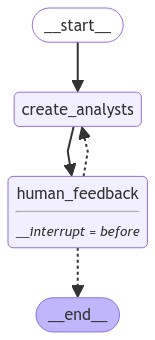

In [ ]:
# 导入显示工具，用于在 Jupyter Notebook 中展示图片
from IPython.display import Image, display
# 导入 LangGraph 的起始节点 START、结束节点 END、以及 StateGraph（状态图构建器）
from langgraph.graph import START, END, StateGraph
# 导入内存检查点，用于保存运行过程中的中间状态
from langgraph.checkpoint.memory import MemorySaver
# 导入消息类型：AIMessage（AI 消息）、HumanMessage（人类消息）、SystemMessage（系统消息）
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


# 定义分析师的指令模版
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""


# 定义创建分析师的函数，输入是当前的状态
def create_analysts(state: GenerateAnalystsState):
    """ 创建分析师 """

    # 从 state 中取出研究主题
    topic = state['topic']
    # 取出最大分析师数量
    max_analysts = state['max_analysts']
    # 获取人类反馈（可能为空字符串）
    human_analyst_feedback = state.get('human_analyst_feedback', '')
        
    # 设置结构化输出，确保 LLM 输出符合 Perspectives 模型
    structured_llm = llm.with_structured_output(Perspectives)

    # 格式化系统提示，将主题、反馈、分析师数量写入
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback, 
        max_analysts=max_analysts
    )

    # 调用 LLM 生成分析师列表
    analysts = structured_llm.invoke(
        [SystemMessage(content=system_message)] + [HumanMessage(content="Generate the set of analysts.")]
    )
    
    # 将生成的分析师列表写回到状态中
    return {"analysts": analysts.analysts}


# 定义人类反馈节点（这里是一个空操作节点，运行时会被中断等待人类输入）
def human_feedback(state: GenerateAnalystsState):
    """ 空节点，执行时会中断，等待人类反馈 """
    pass


# 定义是否继续的判断函数
def should_continue(state: GenerateAnalystsState):
    """ 决定下一个要执行的节点 """

    # 检查是否有人类反馈
    human_analyst_feedback = state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        # 如果有人类反馈，回到 create_analysts 节点，重新生成分析师
        return "create_analysts"
    
    # 如果没有反馈，则直接结束
    return END


# ---------------- 构建 LangGraph 图 ----------------
# 使用 GenerateAnalystsState 作为状态定义，初始化图构建器
builder = StateGraph(GenerateAnalystsState)
# 添加 create_analysts 节点
builder.add_node("create_analysts", create_analysts)
# 添加 human_feedback 节点
builder.add_node("human_feedback", human_feedback)
# 设置边：从 START 到 create_analysts
builder.add_edge(START, "create_analysts")
# 设置边：从 create_analysts 到 human_feedback
builder.add_edge("create_analysts", "human_feedback")
# 设置条件边：从 human_feedback 节点，根据 should_continue 的结果跳转到 create_analysts 或 END
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])


# ---------------- 编译与运行 ----------------
# 创建一个内存保存器，用于存储中间状态（方便回溯和调试）
memory = MemorySaver()
# 编译图，设置在进入 human_feedback 节点前中断，并启用检查点功能
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# ---------------- 可视化 ----------------
# 显示图的结构（以 Mermaid 图的形式画出）
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [ ]:
# 下面的代码逻辑概述

# - 定义输入参数：设置分析师数量、主题、线程 ID。

# - 运行 LangGraph 流程：调用 graph.stream() 实时接收 LangGraph 返回的事件结果。

# - 事件监听与输出：对每个事件检查是否包含分析师（analysts），若有，则输出其基本信息。

## 输入参数，运行图的主流程

# 定义可同时参与分析的分析师（agent）最大数量
max_analysts = 3  

# 定义讨论主题
topic = "The benefits of adopting LangGraph as an agent framework"

# 定义线程配置，用于区分不同的对话或任务（这里设置了一个线程 ID）
thread = {"configurable": {"thread_id": "1"}}

# 运行 LangGraph 的主流程，直到第一次中断（interruption）为止
# 这里使用 graph.stream() 来启动图的流式执行过程
# 参数说明：
# - {"topic": topic, "max_analysts": max_analysts}：输入参数，包括主题和分析师数量
# - thread：指定线程信息，用于任务追踪
# - stream_mode="values"：表示以“事件值”的形式流式返回结果
for event in graph.stream(
    {"topic": topic, "max_analysts": max_analysts},
    thread,
    stream_mode="values"
):
    # 每次循环返回一个事件对象（event）
    # 检查事件中是否包含 'analysts' 字段（即当前分析师信息）
    analysts = event.get('analysts', '')
    
    # 如果包含分析师信息，则遍历输出每位分析师的详细信息
    if analysts:
        for analyst in analysts:
            # 打印分析师姓名
            print(f"Name: {analyst.name}")
            # 打印分析师所属机构或组织
            print(f"Affiliation: {analyst.affiliation}")
            # 打印分析师的角色（例如：技术专家、项目经理、模型评估者）
            print(f"Role: {analyst.role}")
            # 打印分析师的简介或任务描述
            print(f"Description: {analyst.description}")
            # 打印分隔线以便阅读
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technical Analyst
Description: Dr. Carter focuses on the technical benefits and challenges of adopting new frameworks. She is particularly interested in the performance, scalability, and integration capabilities of LangGraph.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Business Insights Group
Role: Business Analyst
Description: Michael examines the business implications of adopting new technologies. He is concerned with cost-benefit analysis, return on investment, and the potential for LangGraph to provide a competitive edge.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: User Experience Research Lab
Role: UX Analyst
Description: Sophia is dedicated to understanding how new frameworks impact user experience. She evaluates the usability, learning curve, and overall satisfaction of developers and end-users when using LangGraph.
-----------------

In [ ]:
# 获取当前线程（thread）的运行状态对象
# 该状态包含图（graph）在本线程中的上下文信息，例如：
# - 已执行过的节点（nodes）
# - 当前节点的输出（values）
# - 下一步要执行的节点（next）
# - 各种内部缓存与执行日志
state = graph.get_state(thread)

# 查看图接下来要执行的节点（next）
# 这通常是一个节点对象或节点名称，用于调试或手动控制流程
# 例如：
# - 若返回 None，说明图已执行完毕
# - 若返回具体节点名，说明下一步 graph.stream() 会从该节点继续执行
state.next

('human_feedback',)

In [ ]:
# 我们现在手动更新图（graph）的状态，就好像当前是在执行名为 "human_feedback" 的节点
# 这常用于模拟人工反馈（human-in-the-loop）过程，例如人类分析师给出的新意见或指令
graph.update_state(
    thread,  # 指定要更新的线程（即之前定义的 thread 对象，用于标识本次对话或任务）
    
    {
        # 在状态中新增或修改的内容（以键值对形式）
        # 这里我们添加了一个名为 "human_analyst_feedback" 的字段，用于记录人类反馈的具体内容
        "human_analyst_feedback": 
            "Add in someone from a startup to add an entrepreneur perspective"  
            # 含义：建议加入一位来自创业公司的分析师，以提供企业家视角
    },
    
    as_node="human_feedback"  
    # 指定此次更新的节点名称为 "human_feedback"
    # 作用：告诉 LangGraph 系统这次状态更新是由 "human_feedback" 节点触发的
    # 这样系统就能在执行流程中识别该更新来源，并在下一步基于反馈调整节点计划
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6c730-ed11-660c-8002-c9533d30fd7b'}}

In [ ]:
# 继续执行图（graph）的剩余部分
# 因为我们之前通过 graph.update_state() 插入了人工反馈，
# 现在通过再次调用 graph.stream() 来让图从上一次中断处继续执行
for event in graph.stream(
    None,          # 输入参数设置为 None，表示从现有状态（state）继续执行，而非重新开始
    thread,        # 指定当前线程（thread），以保持同一个上下文和执行轨迹
    stream_mode="values"  # 指定流式模式为“values”，即逐个返回中间值事件（event）
):
    # 对每次流式返回的事件进行检查和处理
    # 事件（event）可能包含不同类型的数据，如分析师信息、模型输出、任务进度等
    analysts = event.get('analysts', '')
    
    # 如果当前事件包含分析师列表（analysts），则遍历输出他们的详细信息
    if analysts:
        for analyst in analysts:
            # 打印分析师姓名
            print(f"Name: {analyst.name}")
            # 打印所属机构或单位
            print(f"Affiliation: {analyst.affiliation}")
            # 打印分析师的角色或职责
            print(f"Role: {analyst.role}")
            # 打印分析师的描述信息（例如背景、观点、建议等）
            print(f"Description: {analyst.description}")
            # 输出分隔线，方便阅读多个分析师的信息
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technical Analyst
Description: Dr. Carter focuses on the technical benefits and challenges of adopting new frameworks. She is particularly interested in the performance, scalability, and integration capabilities of LangGraph.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Business Insights Group
Role: Business Analyst
Description: Michael examines the business implications of adopting new technologies. He is concerned with cost-benefit analysis, return on investment, and the potential for LangGraph to provide a competitive edge.
--------------------------------------------------
Name: Sophia Martinez
Affiliation: User Experience Research Lab
Role: UX Analyst
Description: Sophia is dedicated to understanding how new frameworks impact user experience. She evaluates the usability, learning curve, and overall satisfaction of developers and end-users when using LangGraph.
-----------------

In [ ]:
# 如果我们对当前图（graph）的分析结果已经满意，
# 就不再提供新的人工反馈（即认为“人类反馈”阶段结束）
further_feedack = None   # 定义一个变量，表示“无进一步反馈”

# 调用 update_state() 来更新图的状态，
# 告诉系统人类反馈节点（human_feedback）这次没有新内容
graph.update_state(
    thread,  # 当前线程对象，用于标识此次更新作用于哪个执行上下文

    {
        # 更新的状态内容，这里设置 human_analyst_feedback 为 None
        # 这表示人类分析师（或用户）没有额外的意见或修改建议
        "human_analyst_feedback": further_feedack
    },

    # 指定此次状态更新对应的节点为 "human_feedback"
    # 这让系统知道这是在人类反馈阶段输入的（即使为空，也可触发下一步执行）
    as_node="human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6c731-5ec7-6e04-8004-626a441d897c'}}

In [ ]:
# 继续执行整个图（graph），直到执行完所有节点（即流程结束）
# 此次执行的目标是查看每个被执行的节点（node）名称，
# 以了解图的完整执行路径或调试执行顺序。
for event in graph.stream(
    None,              # 不提供新的输入，表示从当前状态继续执行
    thread,            # 指定当前线程（即之前任务对应的执行上下文）
    stream_mode="updates"  # 设置流式模式为 "updates"
                         # 表示每次返回一个“状态更新事件”，即每个被执行的节点的输出或变化
):
    # 每当一个节点执行完毕时，会返回一个包含该节点结果的事件对象 event
    print("--Node--")  # 打印分隔符，方便阅读输出

    # 从事件对象中提取当前节点的名称
    # event 是一个字典，其键通常是节点名（例如 "generate_analysts"、"human_feedback"）
    node_name = next(iter(event.keys()))

    # 打印当前执行到的节点名
    print(node_name)

In [ ]:
# 获取图（graph）在当前线程（thread）中的最终状态
# 这一步通常在整个执行流程完成后调用，用于查看执行结果或提取关键输出
# 其中包含：
# - 所有节点的执行结果（values）
# - 最后一次更新的状态（state）
# - 执行历史（history）等信息
final_state = graph.get_state(thread)

# 从最终状态中提取 'analysts' 字段的值
# 说明：
#   - final_state.values 是一个字典，保存了各节点输出的最终汇总结果
#   - 'analysts' 是之前任务中生成的分析师列表（例如模型生成的角色信息）
# 这里将该列表取出以便后续查看或打印分析师的详细资料
analysts = final_state.values.get('analysts')

In [ ]:
# 查看图（graph）在当前线程（thread）中的“下一步待执行节点”
# 说明：
# - final_state 是通过 graph.get_state(thread) 获取的最终状态对象
# - final_state.next 表示图执行完当前节点后，系统计划要执行的下一个节点名称
# 
# 使用场景：
#   ✅ 如果图（graph）尚未完全执行完，final_state.next 会显示下一个节点的名称；
#   ❌ 如果图的流程已经结束（所有节点都执行完毕），则该属性通常为 None。
# 
# 调试用途：
#   - 用于判断图是否执行完毕；
#   - 或在复杂的多分支图中，查看下一个预定的执行路径。
final_state.next

()

In [ ]:
# 遍历最终结果中的所有分析师对象（analysts）
# 每个 analyst 通常是一个包含多项属性的对象（例如 name、role、affiliation、description）
for analyst in analysts:
    # 打印分析师的姓名
    print(f"Name: {analyst.name}")
    
    # 打印分析师的所属机构或单位（例如：大学、公司、研究所）
    print(f"Affiliation: {analyst.affiliation}")
    
    # 打印分析师的角色（例如：AI researcher、product manager、psychologist）
    print(f"Role: {analyst.role}")
    
    # 打印分析师的简要描述或专长背景
    # 通常由模型或人类反馈生成，用于说明该分析师的视角或贡献
    print(f"Description: {analyst.description}")
    
    # 打印分隔线，用于区分不同分析师的输出，增强可读性
    print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Analyst
Description: Dr. Carter focuses on evaluating emerging technologies and their potential impact on various industries. She is particularly interested in how LangGraph can streamline processes and improve efficiency in tech-driven companies.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Green Ventures
Role: Startup Advisor
Description: Michael Thompson is an advisor for early-stage startups, helping them navigate the challenges of growth and innovation. He is keen on understanding how LangGraph can provide a competitive edge to startups by enhancing their operational capabilities.
--------------------------------------------------
Name: Sarah Lee
Affiliation: Global Enterprises Ltd.
Role: Business Strategist
Description: Sarah Lee specializes in developing strategic business plans for large enterprises. She is interested in how LangGraph can be integrated into existi

## Conduct Interview 进行访谈

### Generate Question 生成问题

分析师将向专家提出问题

In [ ]:
# 导入 Python 内置模块和类型注解工具
import operator
from typing import Annotated  # 用于为字段提供额外的元数据或组合操作（例如聚合函数）

# 从 LangGraph 导入基础状态类 MessagesState
# MessagesState 是 LangGraph 用于管理消息流（如对话、节点间信息）的基类
from langgraph.graph import MessagesState


# 定义一个用于“访谈流程”的状态类
# 继承自 MessagesState，以便记录和管理多轮对话（analyst 与 expert 之间）
class InterviewState(MessagesState):
    # 定义允许的状态字段及其类型（带详细说明）

    max_num_turns: int  
    # 表示对话的最大轮数（即 analyst 与 expert 之间的问答次数上限）

    context: Annotated[list, operator.add]
    # 表示上下文信息或参考资料来源的列表（如检索到的文档、摘要等）
    # 使用 Annotated + operator.add 表示当多个节点更新该字段时，会自动累加（append 合并）内容

    analyst: Analyst  
    # 当前负责提问的分析师对象（包含姓名、角色、机构、描述等属性）

    interview: str  
    # 当前访谈的文字记录（transcript），即问答内容的汇总

    sections: list  
    # 用于存储最终整理的访谈关键段落或主题部分
    # 通常会在外层 state 中被复制，用于与 Send() API 交互输出结果


# 定义一个用于检索的查询数据模型
# 继承自 Pydantic 的 BaseModel（用于数据验证与结构化）
class SearchQuery(BaseModel):
    # 定义字段：搜索查询字符串
    # 默认值为 None，并添加字段描述（用于文档生成或 IDE 自动提示）
    search_query: str = Field(
        None, 
        description="Search query for retrieval."  # 用于检索的搜索关键词
    )


In [ ]:
# 定义用于生成问题的系统提示文本（system prompt）
# 这里用三引号定义多行字符串，包含详细的任务说明
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""


# 定义一个用于“生成访谈问题”的函数节点（Node）
# 该节点将从当前对话状态中提取分析师信息，并生成下一轮提问
def generate_question(state: InterviewState):
    """ Node to generate a question """  

    # 从状态（state）中获取分析师对象和当前消息序列
    # state 是 InterviewState 类型，包含对话上下文信息
    analyst = state["analyst"]   # 当前负责提问的分析师对象
    messages = state["messages"] # 之前的对话消息（包括系统消息、用户输入、模型回复等）

    # 构建系统提示语（system message）
    # 使用 format() 将分析师的 persona 信息（即个性或目标）注入到模板中
    system_message = question_instructions.format(goals=analyst.persona)

    # 调用语言模型（llm）生成新问题
    # SystemMessage(content=system_message)：设定模型的行为指令
    # +messages：拼接之前的对话上下文，以便模型保持连续性
    question = llm.invoke([SystemMessage(content=system_message)] + messages)

    # 将模型生成的新问题写回状态（返回一个包含消息列表的字典）
    # LangGraph 会自动将其合并到 state["messages"] 中
    return {"messages": [question]}

### 生成回答：并行化

专家将会**并行地从多个来源收集信息**来回答问题。

例如，我们可以使用以下方式：

* 指定的网站，例如通过 [`WebBaseLoader`](https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/)
* 已建立索引的文档，例如通过 [RAG](https://python.langchain.com/v0.2/docs/tutorials/rag/)
* 网络搜索
* 维基百科搜索

你也可以尝试不同的网络搜索工具，例如 [Tavily](https://tavily.com/)。

In [ ]:
## Set up API keys for Tavily
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [ ]:
## 网络检索工具
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [ ]:
## 维基百科检索工具
from langchain_community.document_loaders import WikipediaLoader

现在，我们将创建用于**搜索网络和维基百科**的节点。

接着，我们会创建一个节点，用于**回答分析师提出的问题**。

最后，我们会创建一些节点，用于**保存完整的访谈内容**，并**撰写访谈摘要（“章节”）**。

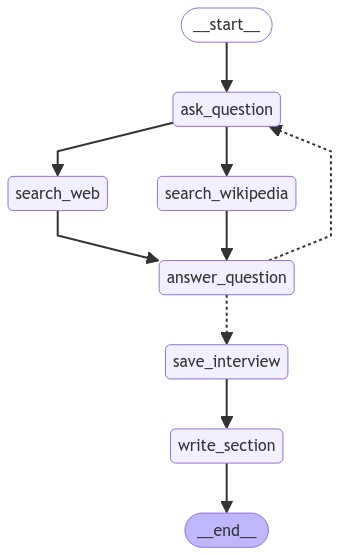

In [ ]:
# 从 LangChain 核心模块导入 get_buffer_string，用于将多轮消息转换为连续字符串
from langchain_core.messages import get_buffer_string


# 定义系统提示（system message）——指导模型如何生成搜索查询
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")


# 定义从 Web 搜索检索文档的节点
def search_web(state: InterviewState):
    """ Retrieve docs from web search """  # 节点功能说明（保持英文原文）

    # 创建结构化 LLM，用于生成 SearchQuery 类型输出（即强制模型输出结构化字段）
    structured_llm = llm.with_structured_output(SearchQuery)

    # 将系统提示 + 当前对话消息传入模型，让模型生成适合搜索的结构化查询语句
    search_query = structured_llm.invoke([search_instructions] + state['messages'])
    
    # 使用 Tavily 工具执行网络搜索，输入为模型生成的搜索查询字符串
    search_docs = tavily_search.invoke(search_query.search_query)

    # 格式化检索到的文档内容，使用 <Document> 标签包装，便于后续引用
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    # 返回 context（上下文），LangGraph 会自动合并到全局状态
    return {"context": [formatted_search_docs]} 


# 定义从维基百科检索文档的节点
def search_wikipedia(state: InterviewState):
    """ Retrieve docs from wikipedia """

    # 同样使用结构化 LLM 生成查询
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state['messages'])
    
    # 使用 WikipediaLoader 执行维基搜索（限制最多加载 2 个文档）
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

    # 格式化维基文档内容，包括 source 和 page 信息
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    # 返回 context 以供回答节点使用
    return {"context": [formatted_search_docs]} 


# 定义专家回答时的系统提示
# 该提示要求专家根据上下文信息回答问题，并附带引用来源
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""


# 定义回答问题的节点
def generate_answer(state: InterviewState):
    """ Node to answer a question """

    # 从状态中提取分析师、消息和上下文
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # 构造系统提示，将分析师的 persona 和上下文内容插入模板
    system_message = answer_instructions.format(goals=analyst.persona, context=context)

    # 调用 LLM 生成回答（作为专家）
    answer = llm.invoke([SystemMessage(content=system_message)] + messages)
    
    # 指定该消息的来源名称为“expert”，方便后续区分发言者
    answer.name = "expert"
    
    # 将回答追加到状态消息中
    return {"messages": [answer]}


# 定义保存完整访谈记录的节点
def save_interview(state: InterviewState):
    """ Save interviews """

    # 获取当前的消息列表
    messages = state["messages"]
    
    # 将消息序列（多轮对话）转换为字符串格式
    interview = get_buffer_string(messages)
    
    # 保存访谈内容到 state["interview"]
    return {"interview": interview}


# 定义路由函数，根据当前状态决定下一步节点（问 or 存）
def route_messages(state: InterviewState, name: str = "expert"):
    """ Route between question and answer """
    
    # 获取消息与最大对话轮数限制
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns', 2)

    # 计算专家已回答的次数
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # 如果超过最大轮数，则跳转至“保存访谈”节点
    if num_responses >= max_num_turns:
        return 'save_interview'

    # 获取最后一个问题，判断是否为结束语
    last_question = messages[-2]
    
    # 如果分析师说了结束语，则结束访谈
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    # 否则继续提问
    return "ask_question"


# 定义撰写访谈总结（section）的系统提示
section_writer_instructions = """You are an expert technical writer. Your task is to create a short, easily digestible section of a 
report based on a set of source documents.

 1. Analyze the content of the source documents: - The name of each source document is at 
the start of the document, with the <Document tag. 

2. Create a report structure using markdown formatting: - Use ## for the section title - Use ### for sub-section headers 

3. Write the report following this structure: a. Title (## header) b. Summary (### header) c. Sources (### header) 

4. Make your title engaging based upon the focus area of the analyst: {focus} 

5. For the summary section: 
- Set up summary with general background / context related to the focus area of the analyst - Emphasize 
what is novel, interesting, or surprising about insights gathered from the interview 
- Create a numbered list of source documents, as you use them 
- Do not mention the names of interviewers or experts 
- Aim for approximately 400 words maximum 
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents 

6. In the Sources section: 
- Include all sources used in your report 
- Provide full links to relevant websites or specific document paths 
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown. 
- It will look like:

### Sources
[1] Link or Document name 
[2] Link or Document name 

7. Be sure to combine sources. For example this is not correct: 

[3] https://ai.meta.com/blog/meta-llama-3-1/ 
[4] https://ai.meta.com/blog/meta-llama-3-1/ 

There should be no redundant sources. It should simply be: 

[3] https://ai.meta.com/blog/meta-llama-3-1/ 

8. Final review: 
- Ensure the report follows the required structure 
- Include no preamble before the title of the report 
- Check that all guidelines have been followed"""


# 定义撰写报告章节的节点
def write_section(state: InterviewState):
    """ Node to answer a question """

    # 从状态中提取访谈内容、上下文和分析师信息
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # 构造系统提示，将分析师关注领域填入模板
    system_message = section_writer_instructions.format(focus=analyst.description)

    # 调用 LLM 撰写报告章节
    # HumanMessage 中传入上下文，提示模型“以这些资料为依据撰写”
    section = llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content=f"Use this source to write your section: {context}")
    ]) 
                
    # 将生成的章节文本添加至 state["sections"]
    return {"sections": [section.content]}


# ---------------- 构建 LangGraph 图结构 ---------------- #

# 创建状态图对象，指定使用 InterviewState 作为状态类型
interview_builder = StateGraph(InterviewState)

# 添加各个节点及其对应的函数
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# 定义节点之间的执行顺序（边）
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")

# 条件跳转：根据 route_messages 的输出决定是继续提问还是结束访谈
interview_builder.add_conditional_edges(
    "answer_question", route_messages, ['ask_question', 'save_interview']
)

# 保存访谈后进入撰写报告阶段
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)


# ---------------- 编译与展示图形 ---------------- #

# 创建内存型检查点保存器，用于记录执行状态
memory = MemorySaver()

# 编译生成完整的可运行图对象，并命名为 "Conduct Interviews"
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# 可视化展示图结构（使用 Mermaid 绘图）
display(Image(interview_graph.get_graph().draw_mermaid_png()))


In [ ]:
# 选择一个分析师
analysts[0]

Analyst(affiliation='Tech Innovators Inc.', name='Dr. Emily Carter', role='Technology Analyst', description='Dr. Carter focuses on evaluating emerging technologies and their potential impact on various industries. She is particularly interested in how LangGraph can streamline processes and improve efficiency in tech-driven companies.')

这里，我们运行访谈时传入了 **llama3.1 论文的索引**，它与我们的主题相关。

In [ ]:
# 从 IPython.display 导入 Markdown，用于在 Jupyter Notebook 中以 Markdown 格式美观展示输出
from IPython.display import Markdown

# 初始化访谈起始消息
# HumanMessage 表示来自人类（分析师）的输入消息
# f-string 动态插入主题变量 {topic}，构造首轮访谈内容
# 例如："So you said you were writing an article on LangGraph?"
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]

# 定义线程（thread）配置，用于在 LangGraph 中区分不同的执行实例
# "thread_id" 用于标识当前访谈的唯一会话编号
# 如果并行运行多个访谈流程，不同线程 ID 可确保状态互不干扰
thread = {"configurable": {"thread_id": "1"}}

# 调用已经构建并编译完成的访谈图（interview_graph）
# invoke() 用于执行整个图流程（非流式执行）
# 输入参数包括：
#   - "analyst": 分析师对象（从之前生成的 analysts 列表中取第一个）
#   - "messages": 初始消息（即上面定义的第一句话）
#   - "max_num_turns": 最大访谈轮数（这里限制为 2 轮问答）
# thread：指定当前执行线程配置
interview = interview_graph.invoke(
    {"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, 
    thread
)

# 访谈流程执行结束后，LangGraph 会输出多个键，如：
# {
#   'messages': [...],
#   'interview': '完整访谈记录',
#   'sections': ['基于访谈生成的摘要章节']
# }

# 使用 Markdown() 函数将生成的访谈报告章节（sections[0]）
# 以 Markdown 格式展示在 Notebook 输出中
Markdown(interview['sections'][0])


## LangGraph: Revolutionizing Agentic Applications in Tech-Driven Industries

### Summary

In the rapidly evolving landscape of emerging technologies, LangGraph stands out as a transformative tool for building stateful, multi-actor applications with large language models (LLMs). Dr. Carter's focus on evaluating such technologies reveals LangGraph's potential to streamline processes and enhance efficiency in tech-driven companies. This report delves into the core principles and benefits of LangGraph, highlighting its unique features and industry applications.

LangGraph, launched in January 2023, is a low-level orchestration framework designed to build agentic applications. It offers unparalleled controllability, allowing developers to define complex workflows involving cycles, which are essential for most agentic architectures [1]. This level of control is crucial for creating sophisticated, customized agentic systems that can adapt to specific business needs [2].

One of the most novel aspects of LangGraph is its ability to balance agent control with agency. This balance is achieved through its core principles: cycles, controllability, and persistence. These principles enable the creation of fully customizable agentic workflows, as opposed to rigid, boilerplate solutions [3]. This flexibility is particularly beneficial for developing advanced chatbots and other interactive applications that require nuanced and dynamic interactions [4].

LangGraph Studio further enhances the development process by providing an integrated development environment (IDE) tailored for agentic applications. This IDE streamlines the creation, testing, and deployment of agentic workflows, making it easier for developers to harness the full potential of LangGraph [5].

The integration of LangGraph with Semantic Web technologies, such as RDF and OWL, offers additional advantages. These technologies enable the encoding of semantics with data, making it machine-readable and facilitating reasoning over heterogeneous data sources [6]. This integration positions LangGraph as a powerful tool for building intelligent systems that can operate across diverse data environments.

In summary, LangGraph represents a significant advancement in the development of agentic applications. Its core principles of cycles, controllability, and persistence, combined with the capabilities of LangGraph Studio and Semantic Web integration, make it a valuable asset for tech-driven companies looking to enhance efficiency and streamline processes.

### Sources
[1] https://github.com/langchain-ai/langgraph/  
[2] https://infohub.delltechnologies.com/en-us/l/rethinking-hierarchical-text-classification-insights-from-multi-agent-experiments-with-small-language-models-1/use-of-langgraph-6/  
[3] https://langchain-ai.github.io/langgraph/concepts/high_level/  
[4] https://www.linkedin.com/pulse/what-langgraph-how-useful-building-llm-based-sarfraz-nawaz-walic/  
[5] https://blog.langchain.dev/langgraph-studio-the-first-agent-ide/  
[6] https://en.wikipedia.org/wiki/Semantic_Web

### 并行化访谈：Map-Reduce

我们通过 `Send()` API 实现访谈的**并行化处理**，这相当于 **Map 步骤**。

然后，在 **Reduce 步骤** 中，将这些访谈结果**合并**到报告正文中。

### 完成报告

我们再添加一个**最终步骤**，为完整报告撰写**引言（intro）**和**结论（conclusion）**。

In [ ]:
# 导入 Python 内置模块与类型提示工具
import operator
from typing import List, Annotated
from typing_extensions import TypedDict  # 用于定义结构化的字典类型（类似 dataclass，但更灵活）

# 定义研究流程（ResearchGraph）的状态结构
# 该类继承自 TypedDict，用于为 LangGraph 或多节点工作流提供强类型状态描述
class ResearchGraphState(TypedDict):
    topic: str  
    # 研究主题（如 "The benefits of adopting LangGraph as an agent framework"）
    # 用于指导分析师和模型聚焦某个具体领域进行访谈与报告撰写

    max_analysts: int  
    # 分析师的最大数量（并行工作的 agent 数量上限）
    # 控制并行执行时启动多少个分析节点

    human_analyst_feedback: str  
    # 人类分析师的反馈内容（可选）
    # 用于在执行中途人工干预、修正模型输出或添加新的分析方向

    analysts: List[Analyst]  
    # 分析师对象列表
    # 每个 Analyst 通常包含：name、affiliation、role、description 等属性
    # 在访谈流程中代表“提出问题的人”

    sections: Annotated[list, operator.add]  
    # 存放多个访谈生成的报告部分（section）
    # 使用 Annotated + operator.add 表示多个节点的输出会自动累加（即 append 合并）
    # 例如多个分析师并行访谈后，其报告片段会自动汇总成完整内容
    # “Send() API key” 表明该字段支持 LangGraph 的 Send() 并行通信机制

    introduction: str  
    # 最终报告的引言部分（Introduction）
    # 通常由单独节点生成，用于介绍研究背景、目的和结构

    content: str  
    # 报告的主体内容（Content）
    # 一般由并行生成的多个访谈摘要（sections）合并而成，是报告的主要部分

    conclusion: str  
    # 最终报告的结论部分（Conclusion）
    # 对研究内容进行总结，提出主要发现或未来方向

    final_report: str  
    # 最终完整报告文本（Final Report）
    # 由 introduction + content + conclusion 拼接而成
    # 通常为系统最终输出的成果，可直接导出或展示

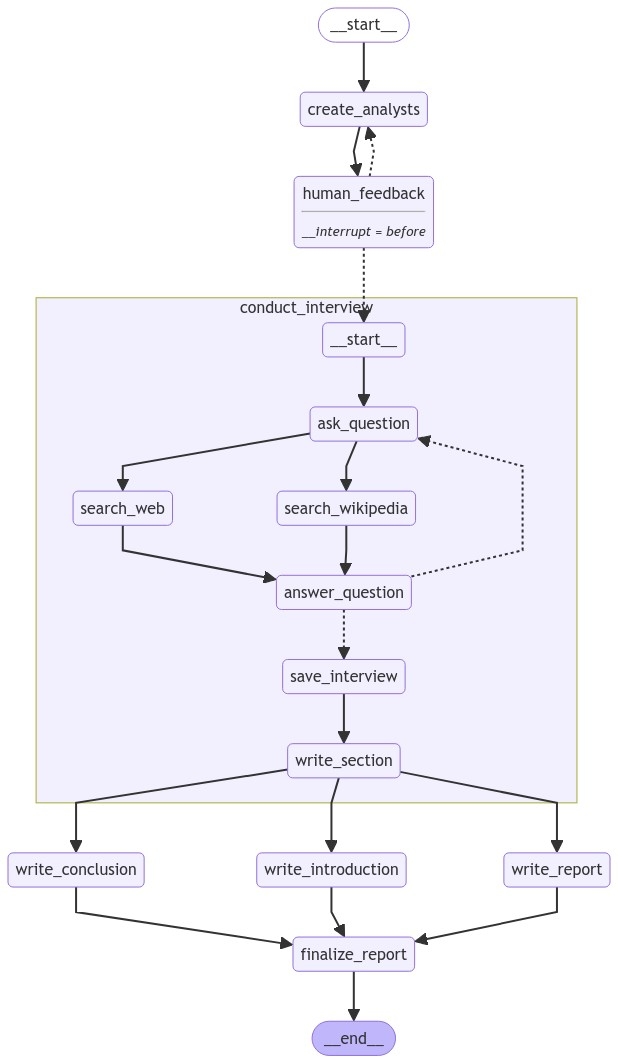

In [ ]:
# 从 LangGraph 导入 Send，用于在 Map 阶段（并行执行）中发送子任务
from langgraph.constants import Send


def initiate_all_interviews(state: ResearchGraphState):
    """
    这是“map”阶段函数（Map Step）。
    功能：决定如何启动多个访谈子任务。
    
    逻辑说明：
    - 若存在人类反馈（human_analyst_feedback），则返回“create_analysts”节点，表示需要重新生成分析师；
    - 否则，通过 Send() API 并行启动每位分析师的访谈子图（conduct_interview）。
    """
    
    # 检查是否有人类反馈存在
    human_analyst_feedback = state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # 如果有人工反馈，则回到“create_analysts”节点重新创建分析师
        return "create_analysts"

    # 否则，通过 Send() API 并行启动所有访谈
    else:
        topic = state["topic"]  # 获取研究主题

        # 返回一个 Send() 列表，每个 Send() 表示一个访谈子任务
        # conduct_interview：子图名称
        # analyst：对应的分析师对象
        # messages：初始消息，用于启动访谈
        return [
            Send(
                "conduct_interview",  # 子图节点名
                {
                    "analyst": analyst,
                    "messages": [
                        HumanMessage(
                            content=f"So you said you were writing an article on {topic}?"
                        )
                    ],
                },
            )
            for analyst in state["analysts"]
        ]


# 报告生成阶段的系统提示（System Instructions）
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""


def write_report(state: ResearchGraphState):
    """
    功能：汇总所有分析师撰写的“访谈备忘录（sections）”，生成一份完整的报告正文。
    
    流程：
    1. 从状态中提取所有访谈部分（sections）。
    2. 拼接为一个整体字符串。
    3. 调用语言模型生成整体报告正文。
    """
    
    # 获取所有访谈部分
    sections = state["sections"]
    topic = state["topic"]

    # 将多个 section 合并为一个带换行的字符串
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # 构造系统消息，注入主题与分析师输出的访谈摘要
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    
    # 调用语言模型生成完整报告正文
    report = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content=f"Write a report based upon these memos.")]
    )

    # 返回报告正文内容
    return {"content": report.content}


# 定义生成报告引言与结论的系统提示
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""


def write_introduction(state: ResearchGraphState):
    """
    功能：根据全部访谈部分，生成报告的引言部分。
    流程：
    1. 汇总所有 section；
    2. 构造系统提示；
    3. 调用语言模型生成引言；
    4. 返回生成的文本。
    """
    # 获取访谈部分与主题
    sections = state["sections"]
    topic = state["topic"]

    # 合并所有 sections
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # 构造系统提示
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    
    # 调用 LLM 生成引言
    intro = llm.invoke([instructions] + [HumanMessage(content=f"Write the report introduction")])
    
    # 返回引言部分
    return {"introduction": intro.content}


def write_conclusion(state: ResearchGraphState):
    """
    功能：根据所有 sections，生成报告的结论部分。
    步骤与 write_introduction 基本相同，仅更改提示内容。
    """
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    
    # 调用 LLM 生成结论
    conclusion = llm.invoke([instructions] + [HumanMessage(content=f"Write the report conclusion")])
    
    # 返回结论部分
    return {"conclusion": conclusion.content}


def finalize_report(state: ResearchGraphState):
    """
    功能：这是“reduce”阶段。
    作用：将所有部分（引言、正文、结论）合并成最终报告。
    
    逻辑：
    - 提取正文（content），去除多余标题；
    - 分离 Sources 部分；
    - 拼接 introduction、content、conclusion；
    - 若存在引用，则附加 Sources。
    """
    
    # 获取报告正文
    content = state["content"]

    # 若正文以“## Insights”开头，去掉标题部分
    if content.startswith("## Insights"):
        content = content.strip("## Insights")

    # 尝试拆分正文与引用来源（Sources）
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    # 拼接最终报告（引言 + 主体 + 结论）
    final_report = (
        state["introduction"]
        + "\n\n---\n\n"
        + content
        + "\n\n---\n\n"
        + state["conclusion"]
    )

    # 若存在引用，则附加在最后
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources

    # 返回最终报告文本
    return {"final_report": final_report}


# ---------------- 构建状态图 ---------------- #
# 创建 StateGraph 对象，定义所有节点与逻辑流程
builder = StateGraph(ResearchGraphState)

# 添加节点（对应具体功能模块）
builder.add_node("create_analysts", create_analysts)                 # 创建分析师
builder.add_node("human_feedback", human_feedback)                   # 获取人工反馈
builder.add_node("conduct_interview", interview_builder.compile())   # 执行访谈子图
builder.add_node("write_report", write_report)                       # 撰写报告正文
builder.add_node("write_introduction", write_introduction)           # 撰写报告引言
builder.add_node("write_conclusion", write_conclusion)               # 撰写报告结论
builder.add_node("finalize_report", finalize_report)                 # 汇总生成最终报告


# ---------------- 定义节点连接逻辑 ---------------- #
builder.add_edge(START, "create_analysts")  # 从起点进入创建分析师阶段
builder.add_edge("create_analysts", "human_feedback")  # 创建后进入反馈环节

# 条件边：根据 initiate_all_interviews 的返回值决定执行路径
builder.add_conditional_edges(
    "human_feedback",
    initiate_all_interviews,
    ["create_analysts", "conduct_interview"],
)

# 并行执行访谈后，进入报告撰写阶段
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")

# 当报告主体、引言、结论全部生成后，进入最终整合阶段
builder.add_edge(
    ["write_conclusion", "write_report", "write_introduction"],
    "finalize_report",
)
builder.add_edge("finalize_report", END)  # 执行结束


# ---------------- 编译与可视化 ---------------- #
# 创建内存检查点保存器，用于保存执行状态
memory = MemorySaver()

# 编译整个图，并在“human_feedback”节点前设置中断（允许人工审查）
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# 可视化展示流程图结构
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


现在，让我们问一个关于 LangGraph 的开放性问题。

In [ ]:
# -------------------------------
# 输入参数定义（Inputs）
# -------------------------------

max_analysts = 3  
# 定义分析师的最大数量（即最多并行生成多少个 analyst 角色）
# 每个分析师在后续流程中将代表一个独立视角（例如研究员、创业者、工程师等）

topic = "The benefits of adopting LangGraph as an agent framework"
# 定义研究主题（本次任务的核心讨论主题）
# 所有生成的分析师、访谈内容、报告撰写都将围绕该主题展开

thread = {"configurable": {"thread_id": "1"}}
# 定义执行线程的配置参数
# "thread_id" 用于唯一标识本次执行的上下文（conversation / session）
# 若同时运行多个任务，thread_id 可防止状态冲突或结果混淆


# -------------------------------
# 执行主图（graph）直到遇到第一个中断点（interruption）
# -------------------------------
# graph.stream() 是 LangGraph 的流式执行接口，用于逐步返回中间结果
# 参数说明：
# - {"topic": topic, "max_analysts": max_analysts}：作为输入状态（state）传入图中
# - thread：指定当前执行线程（同一个 thread_id 会共享上下文状态）
# - stream_mode="values"：返回节点计算得到的值（value 层面的事件）
for event in graph.stream(
    {"topic": topic, "max_analysts": max_analysts}, 
    thread, 
    stream_mode="values"
):
    # 每次循环从流中接收到一个事件对象 event
    # event 通常是字典结构，包含一个或多个节点的输出（例如 analysts、messages、content 等）
    
    analysts = event.get('analysts', '')
    # 尝试从当前事件中提取 "analysts" 字段（即分析师列表）
    # 若不存在该字段则返回空字符串 ''

    # 如果当前事件包含分析师对象，则逐一打印其信息
    if analysts:
        for analyst in analysts:
            # 打印分析师的姓名
            print(f"Name: {analyst.name}")
            
            # 打印分析师的所属机构或单位（如公司、研究所、大学等）
            print(f"Affiliation: {analyst.affiliation}")
            
            # 打印分析师的角色（例如 Technical Expert、Entrepreneur、Policy Researcher）
            print(f"Role: {analyst.role}")
            
            # 打印分析师的简介（由模型生成，描述其专长、研究方向或独特视角）
            print(f"Description: {analyst.description}")
            
            # 打印分隔线，便于区分不同分析师的输出结果
            print("-" * 50)


Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technical Analyst
Description: Dr. Carter focuses on the technical advantages and innovations brought by adopting LangGraph. She is particularly interested in how LangGraph can improve system efficiency, scalability, and integration with existing technologies.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Business Insights Group
Role: Business Strategist
Description: Michael Thompson analyzes the business benefits of adopting LangGraph. His focus is on cost reduction, return on investment, and competitive advantage. He evaluates how LangGraph can drive business growth and operational efficiency.
--------------------------------------------------
Name: Samantha Lee
Affiliation: User Experience Research Lab
Role: User Experience Analyst
Description: Samantha Lee examines the user experience improvements that LangGraph can offer. She is concerned with usability, user satisfaction, and t

In [ ]:
# ---------------------------------------------------------------
# 我们现在手动更新图（graph）的执行状态，
# 模拟“human_feedback”节点被触发的情况，
# 即相当于人类用户在中途插入了反馈（human-in-the-loop）。
# ---------------------------------------------------------------

graph.update_state(
    thread,  # 指定要更新的执行线程（对应之前定义的 thread = {"configurable": {"thread_id": "1"}}）
              # LangGraph 支持多线程（多会话）状态管理，这里更新的是 thread_id=1 对应的那条执行路径

    {
        # 定义要更新的状态内容（键值对形式）
        # 这里我们为状态添加一个新的键：human_analyst_feedback
        # 值为用户提供的人类反馈内容，用于指示下一步该如何调整分析师或访谈方向
        "human_analyst_feedback": 
            "Add in the CEO of gen ai native startup"  
            # 含义：建议在分析师团队中加入一位“生成式 AI 原生初创公司的 CEO”
            # 这种反馈常用于提示模型：添加不同视角的专家，以丰富报告的观点结构
    },

    as_node="human_feedback"  
    # 指定此次状态更新是由哪个节点引起的
    # 这里明确标识为 "human_feedback"，告诉系统这是一次“人工干预”节点的更新
    # LangGraph 会据此记录来源，以便在可视化图或日志中标记该节点的状态变化
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a4b4-a84a-6080-8002-b8c1432e2743'}}

In [ ]:
# -------------------------------------------------------------
# 检查（Check）阶段
# 在我们更新了 human_feedback 状态之后，
# 通过再次运行 graph.stream() 来继续执行图的剩余部分，
# 让系统基于新的人工反馈重新生成或调整分析师列表。
# -------------------------------------------------------------

for event in graph.stream(
    None,             # 设置为 None，表示不传入新的输入数据，
                      # 而是从上一次中断的位置继续执行（基于已有 state）
    thread,           # 指定同一个线程上下文（thread_id = "1"），
                      # 保证状态连续性与一致性
    stream_mode="values"  # 使用 "values" 模式流式返回节点输出的值（而不是状态更新信息）
):

    # 每次循环接收到一个事件（event），
    # 该事件包含当前节点生成的输出数据，例如 analysts、messages、content 等。
    analysts = event.get('analysts', '')
    # 尝试从事件对象中提取分析师列表（analysts），
    # 如果当前节点输出中没有该字段，则返回空字符串 ''

    # 如果事件中包含分析师数据，则逐一输出他们的信息
    if analysts:
        for analyst in analysts:
            # 打印分析师姓名
            print(f"Name: {analyst.name}")
            
            # 打印分析师所属机构或组织（如公司、研究院、大学）
            print(f"Affiliation: {analyst.affiliation}")
            
            # 打印分析师的角色（例如：AI Engineer、CEO、Research Scientist）
            print(f"Role: {analyst.role}")
            
            # 打印分析师的描述（通常包括其专长领域或提供的独特视角）
            print(f"Description: {analyst.description}")
            
            # 打印分隔线以区分不同分析师，便于阅读
            print("-" * 50)
# 通过上述循环，我们可以看到在插入人类反馈后，
# 系统重新生成的分析师列表，
# 其中应包含一位“生成式 AI 原生初创公司的 CEO”，
# 以验证反馈已被正确应用。

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technical Analyst
Description: Dr. Carter focuses on the technical advantages and innovations brought by adopting LangGraph. She is particularly interested in how LangGraph can improve system efficiency, scalability, and integration with existing technologies.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Business Insights Group
Role: Business Strategist
Description: Michael Thompson analyzes the business benefits of adopting LangGraph. His focus is on cost reduction, return on investment, and competitive advantage. He evaluates how LangGraph can drive business growth and operational efficiency.
--------------------------------------------------
Name: Samantha Lee
Affiliation: User Experience Research Lab
Role: User Experience Analyst
Description: Samantha Lee examines the user experience improvements that LangGraph can offer. She is concerned with usability, user satisfaction, and t

In [ ]:
# -------------------------------------------------------------
# 确认我们对当前分析师团队或系统生成的结果满意（Confirm we are happy）
# 即表示“没有进一步的人类反馈（No more feedback）”，
# 所以我们将 human_analyst_feedback 字段设为 None，
# 让 LangGraph 知道可以继续执行后续流程（例如开始访谈阶段）。
# -------------------------------------------------------------

graph.update_state(
    thread,  # 指定要更新的执行线程对象
              # 这里依然是 {"configurable": {"thread_id": "1"}}
              # 用于标识要修改哪个会话或执行上下文的状态

    {
        # 设置状态更新内容：
        # 将 human_analyst_feedback 设置为 None，表示不再提供新的反馈
        # 这意味着当前人工干预阶段（human_feedback node）结束，
        # 系统可以继续向下执行（例如启动 conduct_interview 子图）
        "human_analyst_feedback": None
    },

    as_node="human_feedback"  
    # 指定此次状态更新的来源节点为 "human_feedback"
    # 这样 LangGraph 在执行记录或可视化中会明确显示：
    # 本次状态修改来自 human_feedback 节点（即人工确认阶段）
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a4b5-4229-61e2-8004-d32a00c0326b'}}

In [ ]:
# -------------------------------------------------------------
# 继续执行图（Continue）
# 在确认用户没有更多反馈（human_analyst_feedback=None）之后，
# 我们重新运行 graph.stream()，让 LangGraph 从上一次中断处继续执行。
# 这将依次执行剩余节点（例如访谈、报告撰写等），
# 并通过 "updates" 模式实时显示每个被执行的节点名称。
# -------------------------------------------------------------

for event in graph.stream(
    None,             # 不传入新的输入（None），表示从当前状态继续执行
    thread,           # 指定同一个线程上下文（thread_id="1"），确保执行状态连贯
    stream_mode="updates"  # 设置流式模式为 "updates"
                          # 表示每次返回的是节点的“更新事件”，
                          # 即每个被执行节点的状态变更，而不仅仅是输出值
):
    # 每当一个节点被执行时，LangGraph 会返回一个事件（event），
    # event 是一个字典，键是节点名，值是节点的执行结果或状态更新内容。
    
    print("--Node--")  
    # 打印分隔符，方便在输出中直观地看到节点执行的顺序分隔
    
    node_name = next(iter(event.keys()))
    # 获取当前事件中被执行的节点名称。
    # 由于每个 event 通常只包含一个键（即节点名），
    # 因此使用 next(iter(event.keys())) 来取第一个键即可。
    
    print(node_name)
    # 打印节点名称，方便我们了解当前执行进度（例如 “conduct_interview”、“write_report” 等）

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [ ]:
# -------------------------------------------------------------
# 导入 Markdown 显示模块
# -------------------------------------------------------------
from IPython.display import Markdown  
# 从 IPython.display 模块导入 Markdown 类，
# 用于在 Jupyter Notebook 或 Colab 等交互环境中以 Markdown 格式渲染文本输出，
# 从而保留标题、加粗、列表等格式效果，让报告更易读。


# -------------------------------------------------------------
# 获取图（graph）的最终状态对象
# -------------------------------------------------------------
final_state = graph.get_state(thread)
# 调用 graph.get_state() 获取当前线程（thread）对应的完整执行状态。
# 参数 thread 是 {"configurable": {"thread_id": "1"}}，
# 用于指明要读取哪一条执行路径的状态数据。
#
# 返回的 final_state 是一个包含图执行所有上下文的对象，
# 其中包括：
#   - values：存储各节点的输出结果（如 analysts、sections、final_report 等）
#   - next：指示下一个待执行的节点（若流程已完成则为 None）
#   - history：记录节点执行顺序和结果快照
# 这一步通常在整个图执行结束后调用，用于提取最终产出。


# -------------------------------------------------------------
# 从最终状态中提取完整报告（Final Report）
# -------------------------------------------------------------
report = final_state.values.get('final_report')
# 从状态对象的 values 字典中读取键名为 "final_report" 的内容，
# 即系统生成的最终完整研究报告。
#
# “final_report” 通常由 finalize_report() 节点生成，
# 该节点整合了 introduction、content、conclusion 三部分内容，
# 并在必要时附加 Sources（引用来源）。
#
# 使用 .get() 方法的好处是：
#   - 若不存在该键，不会报错；
#   - 返回值默认为 None，方便后续检查。


# -------------------------------------------------------------
# 以 Markdown 格式渲染输出报告
# -------------------------------------------------------------
Markdown(report)
# 将报告内容以 Markdown 形式显示。
# Markdown() 会将字符串渲染为富文本，
# 保留报告中包含的 Markdown 标题（#、##）、分隔线（---）、
# 引用标记、编号列表、链接等格式。
#
# 例如，若报告内容为：
#   "# The Benefits of LangGraph\n\n## Introduction\n..."
# 则输出结果会自动渲染成带格式的可读报告。

# The Benefits of Adopting LangGraph as an Agent Framework

## Introduction

In the rapidly evolving landscape of artificial intelligence, businesses are increasingly seeking advanced technologies to streamline operations and enhance efficiency. LangGraph, a robust framework for building stateful, multi-actor applications with large language models (LLMs), stands out as a transformative tool. This report delves into the strategic business efficiencies offered by LangGraph, its role in enhancing generative AI models for scalability and market competitiveness, and its impact on data security and privacy. By exploring these facets, we aim to highlight how LangGraph can be a game-changer for businesses looking to leverage AI for complex task automation and operational excellence.

---



In the rapidly evolving landscape of artificial intelligence, businesses are increasingly adopting advanced technologies to streamline operations, enhance efficiency, and maintain robust data security. LangGraph, a robust framework for building stateful, multi-actor applications with large language models (LLMs), stands out as a transformative tool for these purposes. This report consolidates insights from various analyses to highlight the strategic benefits of adopting LangGraph as an agent framework.

LangGraph excels in handling complex, bespoke tasks essential for modern business operations. Unlike simpler frameworks, LangGraph is adept at creating and managing sophisticated workflows involving multiple AI agents, making it particularly beneficial for businesses looking to automate complex processes and improve operational efficiency.

Key insights from the analysis of LangGraph include:

1. **Stateful Multi-Actor Applications**: LangGraph's ability to build stateful applications allows for the creation of dynamic and adaptive workflows. This is crucial for businesses that require real-time adjustments based on evolving data and task requirements [1][2].

2. **Cycles, Controllability, and Persistence**: These core benefits of LangGraph enable businesses to define cyclical processes, maintain control over AI agent actions, and ensure the persistence of data and states across sessions. This leads to more reliable and consistent performance of AI-driven operations [2][3].

3. **Integration and Scalability**: LangGraph's framework supports the integration of diverse AI agent types within a unified system, facilitating the development of scalable solutions. This is particularly advantageous for businesses aiming to expand their AI capabilities without overhauling existing systems [4][5].

4. **Enhanced Performance Evaluation**: By providing tools to evaluate and optimize AI performance, LangGraph helps businesses ensure that their AI solutions are not only effective but also efficient. This is critical for maintaining competitive advantage in a technology-driven market [1][5].

5. **Custom LLM-Backed Experiences**: LangGraph enables the creation of custom experiences powered by LLMs, which can be tailored to specific business needs. This customization potential allows businesses to develop unique solutions that address their particular challenges and opportunities [1][4].

LangGraph also enhances the capabilities of generative AI models, improving scalability and providing a competitive edge in the market. By facilitating the creation of cyclic graphs for LLM-based AI agents, LangGraph allows for more variable and nuanced agent behaviors compared to traditional linear execution models [1]. This approach bridges the gap between the potential of LLMs and the requirements of real-world software development, making it a valuable tool for startups and established businesses alike.

Key insights from this perspective include:

1. **Framework for Controlled AI Applications**: LangGraph provides a structured framework for creating controlled, production-ready AI applications, which is essential for meeting the stringent requirements of real-world software development [1].

2. **Cyclic Graph Topologies**: By viewing agent workflows as cyclic graph topologies, LangGraph enables more nuanced and variable agent behaviors, enhancing the flexibility and adaptability of AI models [2].

3. **Integration with LangChain**: LangGraph is built on top of LangChain, leveraging its capabilities to create more efficient and stateful multi-actor applications. This integration allows for better coordination and checkpointing of different chains or actors using regular Python functions [4].

4. **Real-World Applications**: LangGraph has been successfully applied in complex data analysis scenarios, demonstrating its practical utility and effectiveness in handling diverse AI agent types within a unified framework [5].

5. **Improving Retrieval-Augmented Generation (RAG)**: LangGraph, in conjunction with LangChain, can significantly improve RAG by creating more efficient and conditional workflows, which are essential for generating accurate and contextually relevant responses [6].

In the context of data security and privacy, LangGraph offers a structured framework for defining, coordinating, and executing multiple LLM agents, which can significantly streamline the development of complex AI applications. One of its key features is the ability to create cyclical graphs, essential for developing stateful, multi-actor applications [1]. This capability can enhance the efficiency and reliability of AI-driven processes, which is critical for maintaining data integrity.

However, LangGraph does not enforce best practices as rigorously as some other tools. This flexibility can lead to suboptimal results if developers do not adhere to established security protocols [2]. Despite this, LangGraph's higher level of control can be advantageous for developers who are well-versed in data security practices.

The recent release of LangGraph v0.2 introduces new checkpointer libraries, including a SQLite checkpointer for local workflows and an optimized Postgres checkpointer for production environments [3]. These enhancements provide increased customization options, which can be leveraged to improve data security measures. Additionally, the introduction of LangGraph Cloud offers new opportunities for scalable and secure AI application development.

In summary, LangGraph offers a comprehensive solution for businesses looking to leverage AI for complex task automation, operational efficiency, and data security. Its unique features and strategic advantages make it a valuable tool for businesses aiming to stay ahead in a competitive market.


---

## Conclusion

LangGraph emerges as a transformative framework for businesses aiming to leverage AI for enhanced operational efficiency, scalability, and data security. By enabling the creation of stateful, multi-actor applications, LangGraph addresses the complex needs of modern enterprises. Its unique features, such as cycles, controllability, and persistence, offer significant advantages in automating intricate workflows. The integration and scalability capabilities further ensure that businesses can expand their AI solutions seamlessly. Additionally, LangGraph's tools for performance evaluation and custom LLM-backed experiences provide a competitive edge in the market. Despite some challenges in enforcing best practices, LangGraph's advanced features and recent updates make it a valuable asset for businesses focused on strategic efficiency, generative AI model enhancement, and robust data security.

## Sources
[1] https://www.langchain.com/langgraph  
[2] https://github.com/langchain-ai/langgraph  
[3] https://medium.com/@ga3435/ai-agentic-frameworks-2022fe43e78a  
[4] https://www.datacamp.com/tutorial/langgraph-tutorial  
[5] https://github.com/langchain-ai/langgraph/discussions/1093  
[6] https://medium.com/data-science-in-your-pocket/improving-rag-using-langgraph-and-langchain-bb195bfe4b44  
[7] https://opendatascience.com/langgraph-the-future-of-production-ready-ai-agents/  
[8] https://www.analyticsvidhya.com/blog/2024/07/langgraph-revolutionizing-ai-agent/  
[9] https://towardsdatascience.com/how-to-implement-a-genai-agent-using-autogen-or-langgraph-929135afd34d  
[10] https://adasci.org/a-practical-guide-to-building-ai-agents-with-langgraph/  
[11] https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787  
[12] https://blog.langchain.dev/langgraph-v0-2/

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r

# 补充：📊 Final Report 生成时机和自动执行原理

1️⃣ Final Report 什么时候生成？

  final_report 是在 finalize_report 节点中生成的。这个节点会在以下三个节点全部完成后自动执行：

  builder.add_edge(
      ["write_conclusion", "write_report", "write_introduction"],
      "finalize_report",
  )

  执行顺序如下：
  conduct_interview (访谈) 
      ↓ (并行执行)
      ├─→ write_introduction (写引言)
      ├─→ write_report (写正文)
      └─→ write_conclusion (写结论)
           ↓ (三个全部完成后)
      finalize_report (整合最终报告) ← final_report 在这里生成！
           ↓
          END

  ---
  2️⃣ 为什么会自动执行？

  这是 LangGraph 的核心机制 —— Fan-in 模式（扇入模式/汇聚模式）：

  关键代码解析：

  # 第 1708-1710 行：定义三个并行任务
  builder.add_edge("conduct_interview", "write_report")
  builder.add_edge("conduct_interview", "write_introduction")
  builder.add_edge("conduct_interview", "write_conclusion")

  # 第 1713-1716 行：定义 Fan-in（等待三个任务全部完成）
  builder.add_edge(
      ["write_conclusion", "write_report", "write_introduction"],  # 源节点列表
      "finalize_report",  # 目标节点
  )

  LangGraph 的自动调度逻辑：

  1. 并行执行阶段：
    - 访谈（conduct_interview）完成后，LangGraph 会自动并行启动三个写作任务
    - 这三个任务互不依赖，可以同时进行
  2. Fan-in 等待机制：
    - LangGraph 会自动追踪这三个节点的执行状态
    - 只有当 ["write_conclusion", "write_report", "write_introduction"] 这三个节点全部完成时
    - 才会自动触发 finalize_report 节点
  3. 自动整合：
    - finalize_report 函数从 state 中读取三个节点的输出
    - 拼接成完整报告（第 1666-1679 行）：
  final_report = (
      state["introduction"]      # 来自 write_introduction
      + "\n\n---\n\n"
      + content                   # 来自 write_report
      + "\n\n---\n\n"
      + state["conclusion"]       # 来自 write_conclusion
  )

  ---
  3️⃣ 为什么这样设计？—— Map-Reduce 模式

  这是经典的 Map-Reduce 架构：

  Map 阶段（并行分散）:
    conduct_interview → write_introduction
                     → write_report
                     → write_conclusion

  Reduce 阶段（汇总）:
    finalize_report (等待所有 Map 任务完成后整合)

  优势：
  - ✅ 高效：三个写作任务并行，节省时间
  - ✅ 解耦：每个写作任务独立，互不影响
  - ✅ 自动化：无需手动协调，LangGraph 自动管理依赖关系

  ---
  4️⃣ 实际执行流程验证

  从输出日志（第 2018-2030 行）可以看到实际执行顺序：

  --Node--
  conduct_interview    # 第一轮访谈
  --Node--
  conduct_interview    # 第二轮访谈
  --Node--
  conduct_interview    # 第三轮访谈
  --Node--
  write_introduction   # 并行：写引言
  --Node--
  write_conclusion     # 并行：写结论
  --Node--
  write_report         # 并行：写正文
  --Node--
  finalize_report      # ← 三个全部完成后自动执行！

  注意：write_introduction、write_conclusion、write_report 的顺序是不确定的（因为并行），但 finalize_report 一定在它们全部完成后才执行。

  ---
  5️⃣ 总结

  | 问题     | 答案                                                           |
  |--------|--------------------------------------------------------------|
  | 何时生成？  | 当 write_introduction、write_report、write_conclusion 三个节点全部完成后 |
  | 为什么自动？ | LangGraph 的 Fan-in 机制自动追踪依赖关系并触发下一个节点                        |
  | 如何实现？  | 通过 builder.add_edge([多个源节点], 目标节点) 定义等待条件                    |
  | 设计模式   | Map-Reduce：并行处理（Map）→ 汇总整合（Reduce）                           |

  这就是为什么你不需要手动调用 finalize_report，整个流程都是声明式自动化的！LangGraph 会根据你定义的依赖关系图，自动调度执行顺序。

In [ ]:
# END